In [4]:
import numpy as np
import pandas as pd
from nltk import word_tokenize,sent_tokenize
from collections import deque
import random
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
import urllib.request as urllib2
from bs4 import BeautifulSoup

#from tensorflow import Tensorboard

Using TensorFlow backend.


# Generating rap lyrics with recurrent neural networks

I wanted to create a RNN to produce rap lyrics inspired by the rapper MF Doom.

I will explain the code in some detail, but I won't describe the network structure in any detail, since I mostly write these notebooks for myself.

There are many other good sources online, where you can learn the basics of RNN.

The only thing I will say to begin with, is that we want to feed a set of 29 characters into a neural network, and make it predict what the next character should be. This prediction is made on the basis of what the structure of the input data (MF Doom lyrics) is; 

If "e" comes often after "th" in the input data, the network will predict that its a high probability that "e" comes next when we feed it the letters "th"

To get the data, we scrape the website metrolyrics. All the songs are hyperlinks with the tag "a" and class name "title ". We find all of them using beautifulsoup.

In [13]:
url= "http://www.metrolyrics.com/mf-doom-lyrics.html" # URL with a list of all songs
                                                    
page = urllib2.urlopen(url)       
soup = BeautifulSoup(page, "html.parser") 

all_songs = soup.find_all('a', {"class": "title "}) 
all_songs[0]

<a alt="MF Doom Beef Rap lyrics" class="title " href="http://www.metrolyrics.com/beef-rap-lyrics-mf-doom.html" onmousedown="ev('Popular Songs','searcht:beef-rap-lyrics-mf-doom');" title="MF Doom Beef Rap lyrics">
Beef Rap Lyrics
</a>

Here we the hyperlink, href = "....", which is what we want. Some of the songs are not MF doom songs, but recommended songs based on this artist. We dont want them, so we search for all songs which have "MF" in the title and extract only those hyperlinks.

In [17]:
songs = []                                          

for n in range (len(all_songs)):
    if "MF" in all_songs[n]["title"]:
        songs.append(all_songs[n]["href"])
        
        
print(f"{n+1} songs found")        
print(f"Example url: {songs[0]}")

82 songs found
Example url: http://www.metrolyrics.com/beef-rap-lyrics-mf-doom.html


Now we have a list of 82 url's (one for each song), and each of those urls is a webpage where we find the song lyrics. We now define an empty string, and fill it with lyrics from all the songs.

In [156]:
lyrics = ""
n_songs = len(songs)

for n in range(n_songs):

    url = songs[n]
    page = urllib2.urlopen(url)
    
    soup = BeautifulSoup(page, "html.parser")

    verses = soup.find_all('p', {"class": "verse"}) # similar as before, all verses have
                                                    # the tag p, and class name "verse"
    
    print(f"Scraping song {n+1} of {n_songs}", end ="\r")
    
    for m in range(len(verses)): # extract the verses and add them to the lyrics string

         lyrics = lyrics + verses[m].text.replace("\n", " \n ")
         lyrics = lyrics + " \n"

Now we can take a look at the data we have collected so far

In [157]:
lyrics[:100]

'Beef rap could lead to gettin? teeth capped \n Or even a wreath for mom dukes on some grief crap \n I '

In [158]:
characters = list(lyrics)
print(characters[:60])

['B', 'e', 'e', 'f', ' ', 'r', 'a', 'p', ' ', 'c', 'o', 'u', 'l', 'd', ' ', 'l', 'e', 'a', 'd', ' ', 't', 'o', ' ', 'g', 'e', 't', 't', 'i', 'n', '?', ' ', 't', 'e', 'e', 't', 'h', ' ', 'c', 'a', 'p', 'p', 'e', 'd', ' ', '\n', ' ', 'O', 'r', ' ', 'e', 'v', 'e', 'n', ' ', 'a', ' ', 'w', 'r', 'e', 'a']


In [159]:
words = word_tokenize(lyrics)
print(words[:10])

['Beef', 'rap', 'could', 'lead', 'to', 'gettin', '?', 'teeth', 'capped', 'Or']


# Preprocessing

In [160]:
print(f"Data contains {len(words)} words, and {len(characters)} characters.")
print(f"There are {len(set(words))} unique words, and {len(set(characters))} unique characters")

Data contains 12249 words, and 58588 characters.
There are 3321 unique words, and 80 unique characters


That is a lot of unique words, so if we use-one-hot encoding (where each word is transormed to a vector with length equal to the number of unique words), the memory of my laptop can't handle that amount of data. Therefore, we will build a character-level model. The method for creating a word-level model, is almost exactly the same.

 We take the first 20 000 characters, which is enough data for this proof-of-concept project.

In [161]:
num_letters = 20000
X = characters[:num_letters]
unique = sorted(list(set(X)))
len(unique)

72

In this subset of the full dataset, there are 72 unique characters. Since we will use one-hot-encoding, we need two dictionaries: one that maps the character to vector indices, and one that maps from vector indices to characters. This is done below, where we also verify that the dictionary works by translating index 0 to its character representation and then back to index representation.

In [162]:
ind_to_letter = dict((i, j ) for i, j in enumerate(unique))
ind_to_letter[0]

'\n'

In [163]:
letter_to_ind = {unique[n]:n for n in range(len(unique))}
letter_to_ind['\n']

0

Now we create a function to perform the one-hot-encoding. One-hot-encoding can be illustrated by using the example text "abc". We want to encode it into a vector of length 3, since there are 3 unique letters in this example. One way to do that is simply

$$ a \to [1,0,0] ,\quad b \to [0,1,0], \quad c \to [0,0,1] $$

and an equally valid encodig is

$$ a \to [0,1,0] ,\quad b \to [0,0,1], \quad c \to [1,0,0] $$

The idea is that we have one unique vector for every character. And since we have created two dictionaries, which maps between indices and characters, we can use this to transform the dataset (which is now a list of characters), into a list of vectors (each representing a uniqe character). This is done in the function below

In [164]:
def one_hot_encode(X,unique):

    X_one_hot = []                         # Empty list which we will append the o-h-encoded vectors to.
    for n in range(len(X)):
        one_hot = [0]*len(unique)          # Create a vector of 0's, with length equal to number of uniqe letters.
        one_hot[letter_to_ind[X[n]]] = 1   # Map the character X[n] to its index, and insert 1 at that index.
        X_one_hot.append(one_hot)          # Append the vector to the list
        
    return X_one_hot

In [165]:
X_one_hot = one_hot_encode(X,unique)

Now we must decide how many characeters in the past the network should look, to determine what the next character should be. With a longer memory, training takes more time, but it would also result in more coherent output. Let's set the memory length to 30 characers.

We split the data into sequences of 30 characters, which will be the input of the neural network. We could train sequentially on the full dataset (i.e, put the 30 first characters into the network, then the characters from 1:31, then 2:32, etc.) but since the input data (lyrics) has very strong sequential correlation, this would result in inefficient training: In the beginning of training, the network would be fitted to the first verses, but since the language structure of later songs can change drastically from the first songs, the network would be unable to coverge to a good minimum.

In [166]:
memory_length = 30

# Create a deque, essentially a fixed length list,
# which automatically removes first element
# to make place for newer inputs

sequence = deque(maxlen = memory_length)            
sequential_data = []

num_data = len(X_one_hot)

for n in range(num_data):
    print(f"{n}", end = "\r")
    sequence.append(X_one_hot[n])       # Append o-h-vectors to a sequence
    if len(sequence) == memory_length:
        sequential_data.append(np.array(sequence,dtype = "int8"))  
        # Once we have a full deque, add the sequence to data


Just as a sanity check, we check if we con convert the first index of the first sequence from its o-h-vector form to the correct character. Since we get "B", which is also the first letter of the input data, we are happy.

In [167]:
# Test if everything is ok so far
ind = list(sequential_data[0][0]).index(max(list(sequential_data[0][0])))
ind_to_letter[ind]

'B'

Now we shuffle the data to remove the time-correlation of the sequences, and split the data into training and validation sets.

In [168]:
random.shuffle(sequential_data)

training_frac = 0.2
index = int(training_frac*len(sequential_data))


train_data = sequential_data[:-index]
test_data = sequential_data[-index:]

Our goal is to predict the last character in a sequence of 30 characters. The target data which will compare our predictions to, is therefore the last character of every sequence. Here we extract these targets from the data, and define our inputs X, and target outputs y, for both the training and validation data.

In [169]:
def target_data_split(data):
    X = [None]*len(data)
    y = [None]*len(data)
    
    # Separate the first 29 characters and the last character
    # for every sequence.
    
    for n in range(len(data)):
        X[n], y[n] = data[n][:-1], data[n][-1]  
    return np.array(X), np.array(y)             

X_train, y_train = target_data_split(train_data)      
X_test, y_test = target_data_split(test_data)


We are now ready to create the neural network, and start training. The network structure is a long-short-term-memory (LSTM) layer, then a dense layer, followed by a final output layer with softmax activation (since we want the proability distribution of the next letter as output).

In [170]:
model = Sequential()

model.add(LSTM(128, input_shape = (np.array(X_train)[0].shape)))
model.add(Dropout(0.2))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(len(unique), activation = "softmax"))

optimizer = RMSprop(lr =1e-2, decay = 1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["acc"])

In [ ]:
model.summary()

In [181]:
epochs = 10
batch_size = 128
history = model.fit(X_train,y_train, batch_size = batch_size, epochs=epochs,validation_data=(X_test,y_test))

Train on 15977 samples, validate on 3994 samples
Epoch 1/10
15977/15977 [==============================] - 12s 751us/step - loss: 1.6182 - acc: 0.5163 - val_loss: 1.9299 - val_acc: 0.4782
Epoch 2/10
15977/15977 [==============================] - 15s 915us/step - loss: 1.5590 - acc: 0.5303 - val_loss: 1.9921 - val_acc: 0.4722
Epoch 3/10
15977/15977 [==============================] - 16s 1ms/step - loss: 1.5225 - acc: 0.5405 - val_loss: 2.0159 - val_acc: 0.4602
Epoch 4/10
15977/15977 [==============================] - 18s 1ms/step - loss: 1.4654 - acc: 0.5560 - val_loss: 2.0366 - val_acc: 0.4732
Epoch 5/10
15977/15977 [==============================] - 16s 1ms/step - loss: 1.4139 - acc: 0.5662 - val_loss: 2.0225 - val_acc: 0.4654
Epoch 6/10
15977/15977 [==============================] - 16s 985us/step - loss: 1.3726 - acc: 0.5763 - val_loss: 2.1219 - val_acc: 0.4670
Epoch 7/10
15977/15977 [==============================] - 16s 982us/step - loss: 1.3417 - acc: 0.5868 - val_loss: 2.1325 - 

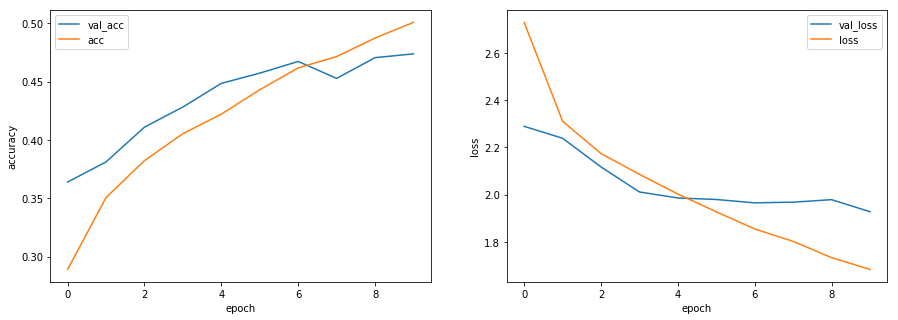

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))

epochs

plt.subplot(1,2,1)
plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["val_acc","acc"])

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["val_loss","loss"])


After traning for 10 epochs, we see that the validation accuracy and validation loss starts to stabilize, so its a good time to stop.

Now we have a model which takes 29 characers as an imput, and gives one proability distribuion of all possible next characters as output.

What we need next, is a function that takes 29 seed characters, the desired length of the output, and a temperature (to be explained later) as input. As the output we want a generated text, where the AI tries to imitate MF Doom. A function that does this is defined below

In [182]:
def generate_rap(seed_sentence:str, length:int , temperature:int, memory=memory_length-1):
    
    cut_seed = list(seed_sentence[:memory])  # We cut the input seed (a user defined string)
                                             # so that it is the same length as our sequence.
    for n in range(len(cut_seed)):
        if cut_seed[n] not in ind_to_letter.values():
            print("Unkown character in input")
            return False    # Report an error if there is a character we havent seen
    
    o_h_seed = np.array(one_hot_encode(cut_seed,unique))  # one-hot-encode the seed
    o_h_sentence = []
    
    for n in range(len(o_h_seed)): 
        o_h_sentence.append(o_h_seed[n]) # append the seed to the output
        
    o_h_seed = o_h_seed.reshape(1,memory,len(unique))
    
    
    for n in range(length):
    
        next_letter = model.predict(np.array(o_h_seed))[0]  # get a model prediction
                            
        next_letter = boltzmann_sample(next_letter,temperature)  # sample probability distribution(see below)
        
        o_h_sentence.append(next_letter) # append the letter to the output
  
        next_letter = np.reshape(next_letter, (1,) + next_letter.shape)

        o_h_seed = np.concatenate((o_h_seed,next_letter), axis = 1)  # add the new letter to the seed
        o_h_seed = np.delete(o_h_seed,obj=0,axis=1)                  # and delete first letter of seed
                                                                     # to keep seed length = 29
            
    str_sentence = ""
    for n in range(len(o_h_sentence)):
        str_sentence += ind_to_letter[np.argmax(o_h_sentence[n])]   # translate the o-h-data to string
    
    print(str_sentence)
    
    
    return o_h_sentence

The way we sample the next letter from the output probability distribution deserves special attention. If we always used the max index value of the output, we would quickly be stuck in a loop i.e. "blood on the blood on the blood" (see below).

We transform the output probability distribution, $p$ into the Boltzmann distribution, $q$:

$$  q_i = \frac{\exp[~\ln(p_i)/T~]}{\sum_i^N \exp[~\ln(p_i)/T~]}, $$

where N is the length of the one-hot-vector output (i.e. the number of unique characters) and T is a parameter. In physics this distribution is the one of a system at equilibrium with temperature T. 

If T = 1, we see that we get back the original probability distribution $q_i = p_i$.

If we sample from this distribution, the temperature T determines how likely we are to sample values with high value of  $p_i$. 


For large $T>>1$, we get a uniform distribution

$$ q_i = 1/N$$

and therefore indpendent on the input $p_i$. This means that we are equally likely to draw any of the possible characters when sampling.


For small $T<<1$, the exponential disribution becomes a delta function, centered on the largest $p_i$

$$ q_i = \delta(p_i-\max(p)) $$

all $q_i$ except for one is zero, while the $q_i$ with the largest $p_i$ as input becomes 1. That is, the zero temperature sampling, is equivalent to always choosing the letter with the largest probability in the output distribution $p$.

In [91]:
def boltzmann_sample(probs, temperature=1.0):
    probs = np.asarray(probs).astype('float64')
    
    probs = np.exp(np.log(probs) / temperature)
    normalization = np.sum(probs)
    
    probs = probs / normalization
    
    sample = np.random.multinomial(1, probs, 1)
    return sample

Below we generate sample texts, while using different temperatures for our sampling.

For low temperatures, where we mostly choose the character with highest probability, we get stuck in loops, such as ("But when he mouth shit the mic the sume follow..."). However, most of the spelling of the words are correct (sume??). The overall structure of the text is repetative, but the words are 

For high temperatures, we get mostly random letters. Most of the words have no meaning, but the text is very diverse.

For intermidate temperatures, we get more coherent sentence structures, and also more diverse word usage.
<img src="golden_zone.png" alt="Drawing" style="width: 500px;"/>

I'm dissapointed I could not find a single good rhyme, but by increasing the data amount, we should be able to improve the rap generator. One thing one could to to force rhyming, is to modify the network character sampling, in such a way that we increase the probability of letters that would result in a rhyme with any words in the past memory.

In [190]:
temperature = 0.01
length = 500
seed = lyrics[:100]
test = generate_rap(seed,length,temperature)

Beef rap could lead to getting with stress 
 But I gottin? up 
 I gotter off the pipe 
 Fresher like sure for what what when he more shit the mic the sume follow 
 But when he mouth shit the mic the sume follow 
 But when he mouth shit the mic the sume follow 
 But when he mouth shit the mic the sume follow 
 But when he mouth shit the mic the sume follow 
 But when he mouth shit the mic the sume follow 
 But when he mouth shit the mic the sume follow 
 But when he mouth shit the mic the sume follow 
 But when he mouth shit


In [185]:
temperature = 0.2
length = 500
seed = lyrics[:100]
test = generate_rap(seed,length,temperature)

Beef rap could lead to getting wonk 
 But when he metto brow 
 I wander when he monk who she while thing of shippin? cailes 
 But when he trunk she wrecks with bust of copped 
 And when he mic the some thing on the mic like the villeet it 
He wast the summer 
 Do mith 
 I wonder like "Super!" 
 got the fuck when he trunk 
 One while this noted the villeet it 
He more with pleasu 
 And when he mouth shit the villeet it 
He kis the mics from the villain in he wastin? bobble 
 And when he metter of shit 
 And while the more sh


In [186]:
temperature = 0.3
length = 500
seed = lyrics[:100]
test = generate_rap(seed,length,temperature)

Beef rap could lead to getting with stress 
 DOOM it 
He wanna see 
 But while still be tippin? 
 Fresed the summer 
 But I'm still glading in come will bast of shit 
 And when he metto brecks with some -clay 
 And while be butten crapher went 
 It she gine crep the villain in the summer 
 But when he mouth with you forget of fleats 
 And when he gonna.le 
 For with 
 But I gottin? up 
 It and went, sting hello 
 It's like ming wonds 
 On the mic toped 
 Freel the knows that's while still bat the villain in the gine live wi


In [187]:
temperature = 0.4
length = 500
seed = lyrics[:100]
test = generate_rap(seed,length,temperature)

Beef rap could lead to getting ofid some follow 
 And when he micting with crapped 
 And when the screams 
 And whith the shit and we mic and shit 
 Freel chat when he gonna live through the villerna brown th crapped 
 And when aut the super-villean-big 
 And when he mitter of maget 
 And when he metto beer 
 But I want her be tomb 
 One butch went 
 I gotta from the browd with more drunk 
 One just gonna see my eyes 
 Steem you don't fairs 
 Do steel 
 from while the bing 
 Crupped 
 And when he mister went 
 The villeet i


In [188]:
temperature = 0.5
length = 500
seed = lyrics[:100]
test = generate_rap(seed,length,temperature)

Beef rap could lead to getting us 
 we tand make get 
 Ove the mic the mock this like The bubble out the brunk like MF Known with my to brecks frimes 
 But I gotty writh the villean 
 It and while shit to croker the wonk the stige in thas in the scrapped 
 Ever me the wasted we arentce 
 But I mistent to what get reat her live the mics never sence 
 On a wuth her bestire 
 Freeh he, whoce stippin? allain 
 Domb will say 
 Get fees 
 They sound for where trick from 
 It could it 
 Leater the womble 
 And her be cottre 
 Thes


In [189]:
temperature = 1.
length = 500
seed = lyrics[:100]
test = generate_rap(seed,length,temperature)

Beef rap could lead to getting bang 
 Right in and mobe suppon, big in and bropen 
 But I top your tough 
 sen leaven to your bubble 
 Off yeall 
 Get kat mos will on kgea h to some 
 villing wettus like Jaz... Ove arwunk des turn 
 I sents from fleats 
OOve, hoak to myster 
 And I see tollow humble dang 
 Do shit, while tho goston 
Fors my bention 
 Let and niggace game 
 And it's ofonone ture 
 But big har 
 but a getter off be fippin? ofilain, heaven, a paighre like Wunk sRuggace 
 Boved priss from the nipped 
 And I'm c
